#Task

We will train a PPO agent which learns to play the classic super mario game.

You can use the stable baselines implementation of PPO or right your own version.

For the env, we will use gym_super_mario_bros. Read more about it [Here](https://github.com/Kautenja/gym-super-mario-bros/)

Note that the stable-baselines3 implementations expect a gymnasium environment and not a gym environment (gymnasium is the upgraded form of gym. gym is depreciated but we can still find a lot of environments made in it.)

Fortunately, gymnasium has a way to resolve that issue and convert a gym env to a gymnasium env. We do need to install a compatible version of gym though.

In [ ]:
!python --version

Python 3.10.12


In [ ]:
%pip install swig
%pip install stable-baselines3 gymnasium[all] gym_super_mario_bros nes_py gym==0.10.9  # might need a restart of the session.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.2 MB/s e

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from gymnasium.wrappers import GrayScaleObservation
import gymnasium as gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from stable_baselines3.common.vec_env import VecFrameStack
import numpy as np
from gymnasium.spaces import Box
import torch as th
from torch import nn
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from pathlib import Path
import datetime
from pytz import timezone
import os


In [ ]:
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

## Making the environment

On top of making the gym requirement, we will make a vectorized environment (provided by stable baselines 3)

This introduces training over multiple environments simultaneously, making the traning faster. We will use DummyVecEnv which doesn't actually use subprocesses but if we were working with a complex environment with higher compute time, we could also use SubProcessVecEnv

Think about what wrappers you can use to make the job easier. You can also make the action-space simpler. Read more about it in the env page referenced above.

Use `'SuperMarioBros-v0'` version of environment

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = gym.make("GymV21Environment-v0", env=env)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

print(f'isinstance(env.observation_space, Box): {isinstance(env.observation_space, Box)}')

state = env.reset()
print("RGB scale : ",state[0].shape)
env = GrayScaleObservation(env, keep_dim=True)
state = env.reset()
print("Gray scale:",state[0].shape)


env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

observation space: Box(0, 255, (240, 256, 3), uint8)
action space: Discrete(7)
isinstance(env.observation_space, Box): True
RGB scale :  (240, 256, 3)
Gray scale: (240, 256, 1)


In [ ]:
env.reset()
state, reward, done, info = env.step([0])
print('state:', state.shape) #env, height, width, num of stacks (colorscale * frameStack)

state: (1, 240, 256, 4)


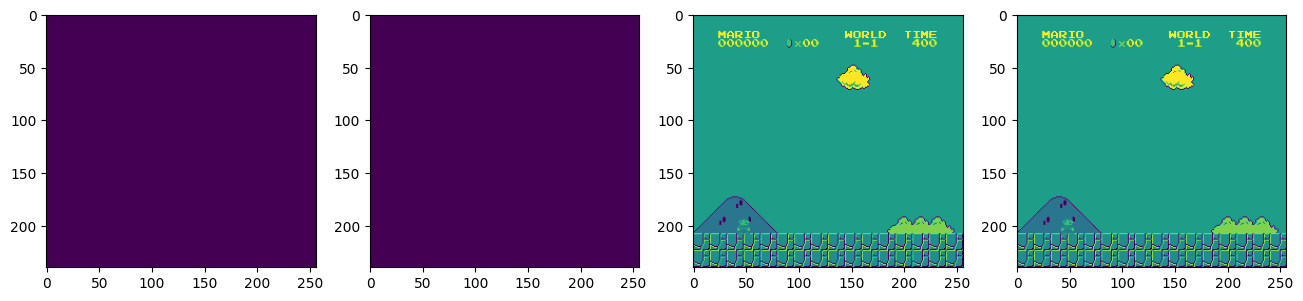

In [ ]:
def display_all_frame():
    plt.figure(figsize=(16,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,state.shape[3],idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()

display_all_frame()


## Creating and training the model

In [ ]:
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 300000
LEARNING_RATE = 0.0001
GAE = 1.0
ENT_COEF = 0.01
N_STEPS = 512
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10

# Test Param
EPISODE_NUMBERS = 20
MAX_TIMESTEP_TEST = 1000

In [ ]:
class MarioNet(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim):
        super(MarioNet, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=MarioNet,
    features_extractor_kwargs=dict(features_dim=512),
)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)



Mounted at /content/gdrive/


In [ ]:
save_dir = Path('/content/gdrive/MyDrive/Colab Notebooks/rl_summer_school/models/mario_model')
# save_dir.mkdir(parents=True)
reward_log_path = (save_dir / 'mario_model_reward_log.csv')

In [ ]:
with open(reward_log_path, 'a') as f:
    print('timesteps,reward,best_reward', file=f)

In [ ]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = (save_dir / 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                while not done and total_time[i] < MAX_TIMESTEP_TEST:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                if total_reward[i] > best_reward:
                    best_reward = total_reward[i]
                    best_epoch = self.n_calls

                state = env.reset()  # reset for each new trial

            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward)

            with open(reward_log_path, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, ',', best_reward, file=f)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq=CHECK_FREQ_NUMB, save_path=save_dir)

In [ ]:
model = PPO('CnnPolicy', env, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log=save_dir, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
              batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA, gae_lambda=GAE, ent_coef=ENT_COEF)

In [ ]:
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB, callback=callback)


## Visualizing the results

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = gym.make("GymV21Environment-v0", env=env, render_mode='rgb_array')
env = GrayScaleObservation(env, keep_dim=True)


t_env = DummyVecEnv([lambda: env])
# t_env = VecFrameStack(t_env, 4, channels_order='last')

state = t_env.reset()
frames = []

while True:
    action, _ = model.predict(state)
    state_next, r, done, info = t_env.step(action)
    state = state_next.copy()
    frames.append(t_env.render())
    if done:
        break
    if len(frames) > 5000:  # to limit the video length in case mario is stuck on untrained models. can be removed
        break

t_env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


In [ ]:
print(len(frames))

5001


In [ ]:
frames_to_video(frames, fps=60)